In [15]:
import numpy as np
import os
import threading
import operator
import pickle
import re
import pandas as pd
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

start_time = 1190146243
end_time = 1192994591

In [2]:
def get_lemma_distribution(file_name):
    lemmas=[]
    with open(file_name) as f:
        for line in f:
            url=line.strip().split(' ')[2]
            if url[7:9] != 'en':
                continue
            lemma=url[url.rfind('/')+1:]
            if ':' in lemma:
                continue
            lemmas.append(lemma)
    return lemmas


def count_lemma(dictionary, lemmas):
    for lemma in lemmas:
        if lemma not in dictionary:
            dictionary[lemma] = 1
        else:
            dictionary[lemma] += 1

            
def get_lemma_counter(num, nworkers = 4):
    data_root = "./data/only_lemma/"
    data_files = os.listdir(data_root)
    counter = {}

    threads = [None] * nworkers
    flags = [True] * nworkers
    
    if num > len(data_files):
        num = len(data_files)
    indices = np.random.choice(len(data_files), num)
    
    def target(index, flags, counter, filename):
        count_lemma(counter, get_lemma_distribution(filename))
        flags[index] = True
        
    j = 1
    
    for i in indices:
        index = 0
        while True:
            try:
                index = flags.index(True)
                flags[index] = False
                break
            except:
                continue
        print("Processing file {}".format(j))
        j += 1
        t = threading.Thread(target = target, args = [index, flags, counter, data_root + data_files[i]])
        threads[index] = t
        t.start()
        
    for thread in threads:
        if thread:
            thread.join()
    return counter

def get_url(entry):
    url = "https://en.wikipedia.org/wiki/{}".format(entry)
    return url
    
def sort_by_value(dictionary):
    sorted_dict = sorted(sort_by_value.items(), key=operator.itemgetter(1))
    return sorted_dict

def dump_data(data, output_name):
    with open(output_name, 'wb') as f:
        pickle.dump(data, f)

def load_data(input_name):
    with open(input_name, 'rb') as f:
        data = pickle.load(f)
    return data

def dump_word_frequency(data, output_dir, num = 2000):
    sorted_dict = sorted(counter.items(), key=operator.itemgetter(1), reverse=True)
    with open(output_dir+'hot_{}.csv'.format(num), 'w') as f:
        f.write("entry\tfrequency\n")
        for i in np.random.choice(100000, num):
            item = sorted_dict[i]
            if len(item[0]) == 0:
                continue
            f.write("{}\t{}\n".format(item[0], item[1]))

/home/xuanli2/penv/lib/python3.5/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


['metadata_90000-100000.pkl', 'metadata_5000-10000.pkl', 'metadata_80000-90000.pkl', 'metadata_50000-60000.pkl', 'metadata_30000-40000.pkl', 'metadata_60000-70000.pkl', 'metadata_40000-50000.pkl', 'metadata_10000-20000.pkl', 'metadata_70000-80000.pkl', 'metadata_0-5000.pkl', 'metadata_20000-30000.pkl']


In [8]:
meta = load_data("data/dump/" + 'metadata_90000-100000.pkl')

In [10]:
meta['Hot_100_number-one_hits_of_1979_%28USA%29'].keys()

dict_keys(['languages', 'image_num', 'links', 'categories'])

In [15]:
from ipywidgets import IntProgress

metadata = {}
files = [name for name in os.listdir("data/dump") if 'metadata' in name]
p = IntProgress(max = 100000)
word_freq = load_data("data/dump/hot_words_100000.pkl") 

display(p)
for file in files:
    meta = load_data("data/dump/" + file)
    for word in meta:
        record = meta[word]
        metadata[word] = {'language_num': len(record['languages']),
                         'image_num': record['image_num'],
                         'link_num': len(record['links']),
                         'category_num': len(record['categories']),
                         'frequency': word_freq[word]}
        p.value += 1

        
metadata = pd.DataFrame(metadata).transpose()
dump_data(metadata, "data/dump/meta_data_num_info.pkl")

IntProgress(value=0, max=100000)

In [4]:
metadata = load_data("data/dump/meta_data_num_info.pkl")

# num of images


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss

def plot_wrt_visit(dataframe, visit_column_name, y_column_name, ylabel, plot_label, output_name):
    
    def interval_of_mean(series, alpha):
        x = np.array(series)
        # https://books.google.com/books?id=ZBi1DAAAQBAJ&pg=PA111&lpg=PA111&dq=python+t_%7Bn-1%7D,%5Calpha/2&source=bl&ots=48wZ7PQS7K&sig=rH-nPDg3iKiaB7RKGGMvuAu31H8&hl=en&sa=X&ved=0ahUKEwj4iKrwpNTaAhUlheAKHcz5AS8Q6AEIQDAC#v=onepage&q=python%20t_%7Bn-1%7D%2C%5Calpha%2F2&f=false
        return ss.norm.interval(alpha, loc = np.mean(x), scale = ss.sem(x))

    def update_sorted_by_access(dataframe):
        tuples = dataframe.apply(lambda row: (int(row[visit_column_name]), int(row[y_column_name])), axis=1)
        return sorted(tuples, key = lambda x: x[0]) 

    sort_list = update_sorted_by_access(dataframe)

    fig = plt.figure(figsize=(10,7))
    mean_data = []
    upper_ci = []
    lower_ci = []
    xlabels = []
    bins = 10
    delta = int(len(dataframe) / bins)
    for j in range(10):
        update = list(map(lambda x: x[1], sort_list[j * delta: (j+1) * delta]))
        access = list(map(lambda x: x[0], sort_list[j * delta: (j+1) * delta]))
        interval = interval_of_mean(update, 0.95)
        lower_ci.append(interval[0])
        upper_ci.append(interval[1])
        mean_data.append(np.mean(update))
        xlabels.append("{}-{}".format((min(access)), (max(access))))
    plt.plot(range(len(mean_data)), mean_data, label = plot_label)
    plt.plot(range(len(mean_data)), upper_ci, label = "Upper Bound of 95% CI")
    plt.plot(range(len(mean_data)), lower_ci, label = "Lower Bound of 95% CI" )
    plt.xticks(range(len(mean_data)), xlabels)
    plt.ylabel(ylabel)
    plt.xlabel("Total Visit")
    plt.legend()
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.tight_layout()
    plt.show()
    fig.savefig("plots/{}".format(output_name), dpi=400)
    

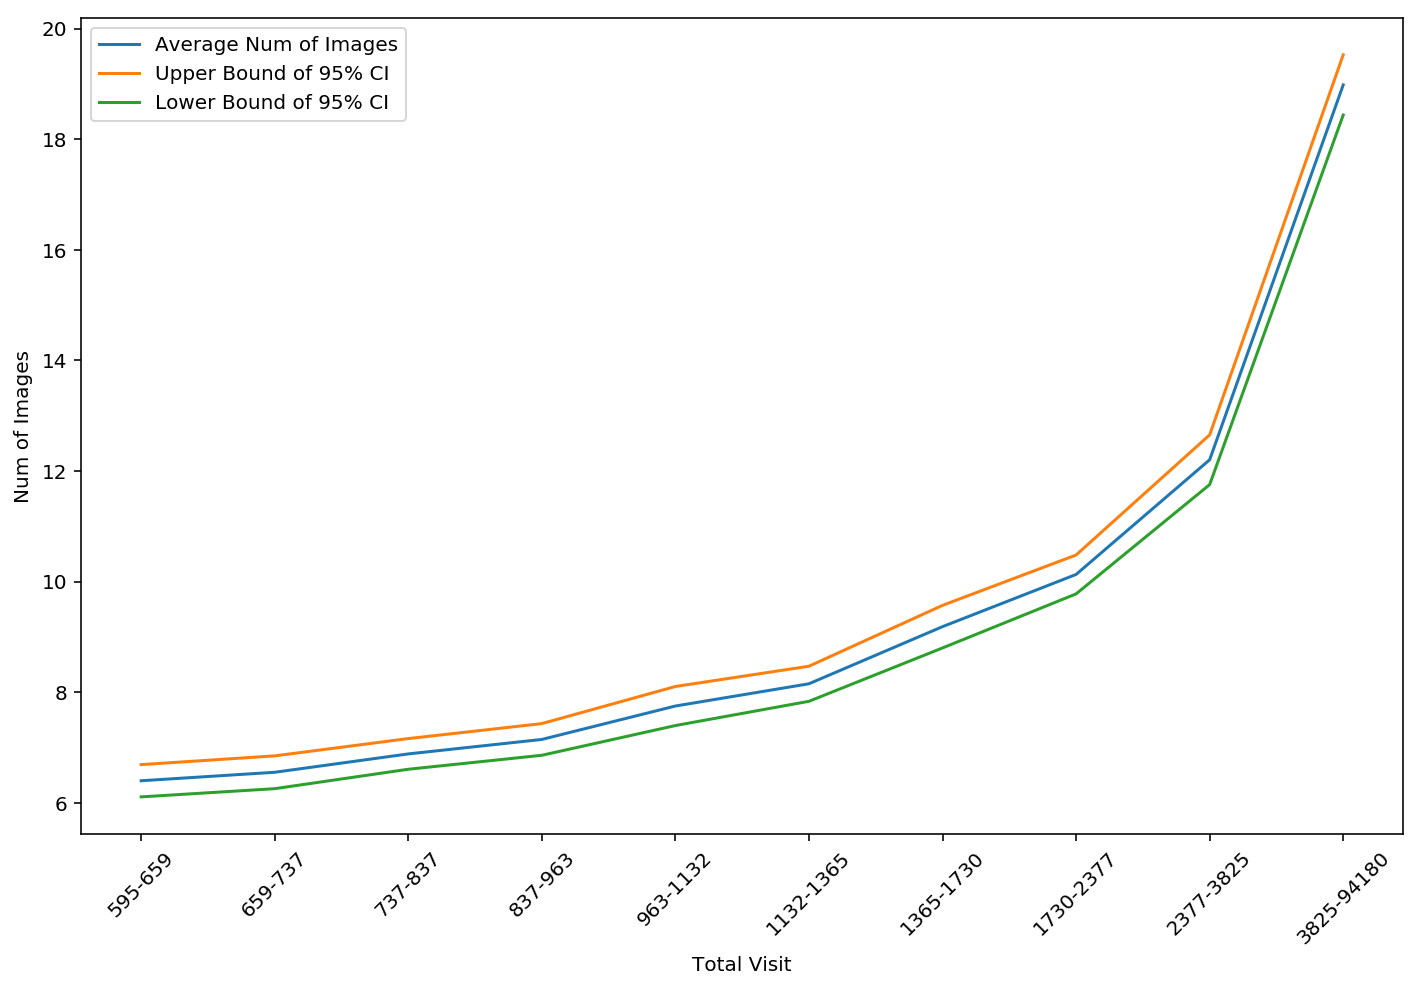

In [7]:
plot_wrt_visit(metadata, 'frequency', 'image_num', 'Num of Images', 'Average Num of Images', 'image_plot.png')

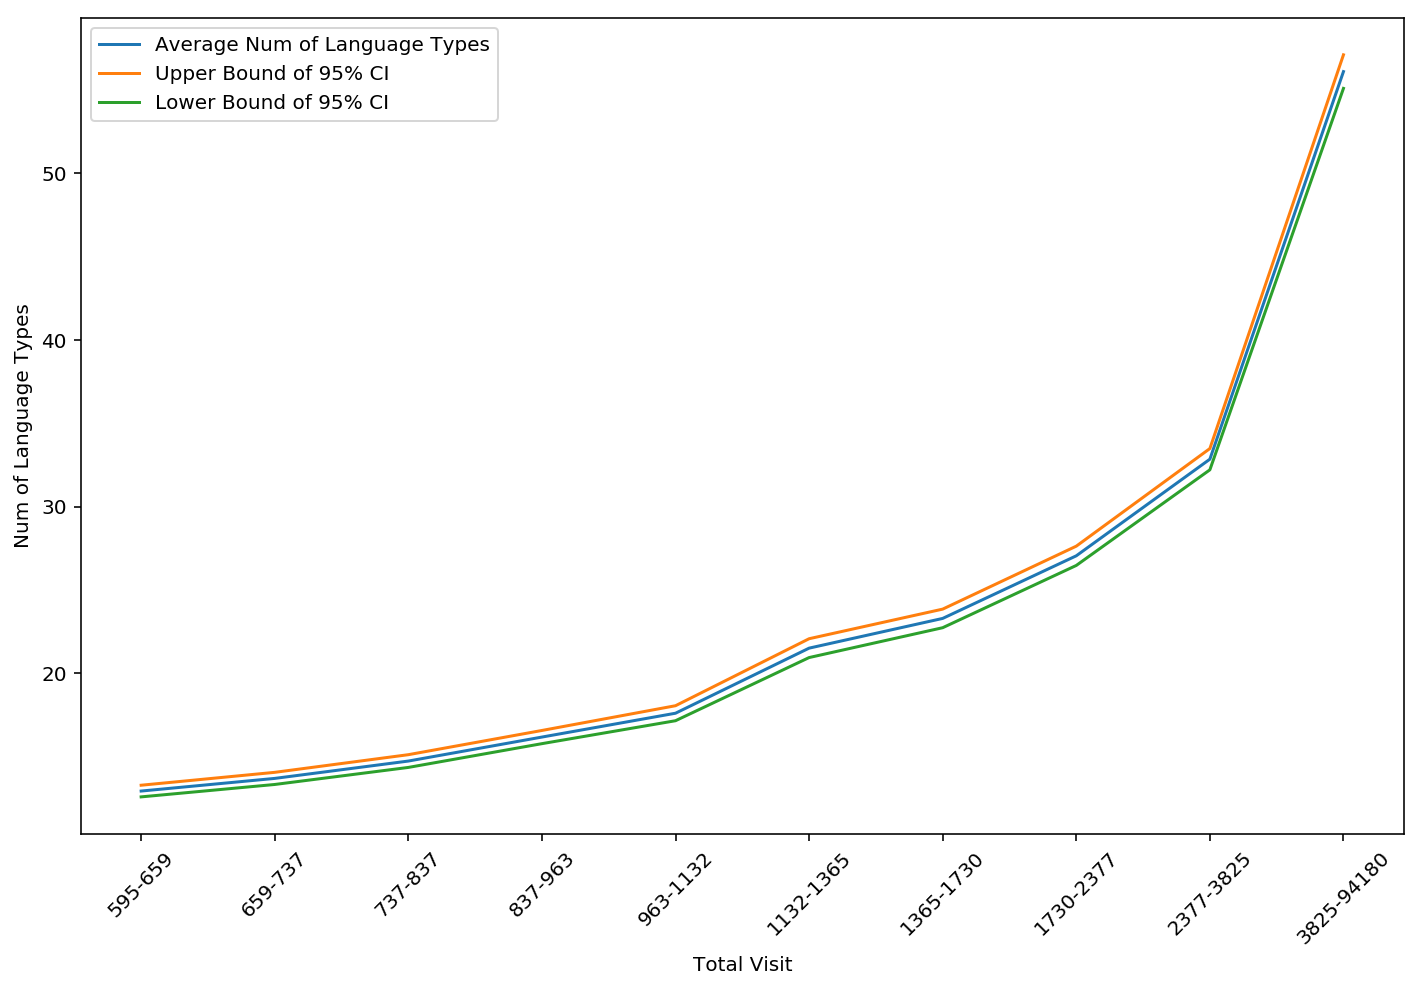

In [8]:
plot_wrt_visit(metadata, 'frequency', 'language_num', 'Num of Language Types', 'Average Num of Language Types', 'language_plot.png')

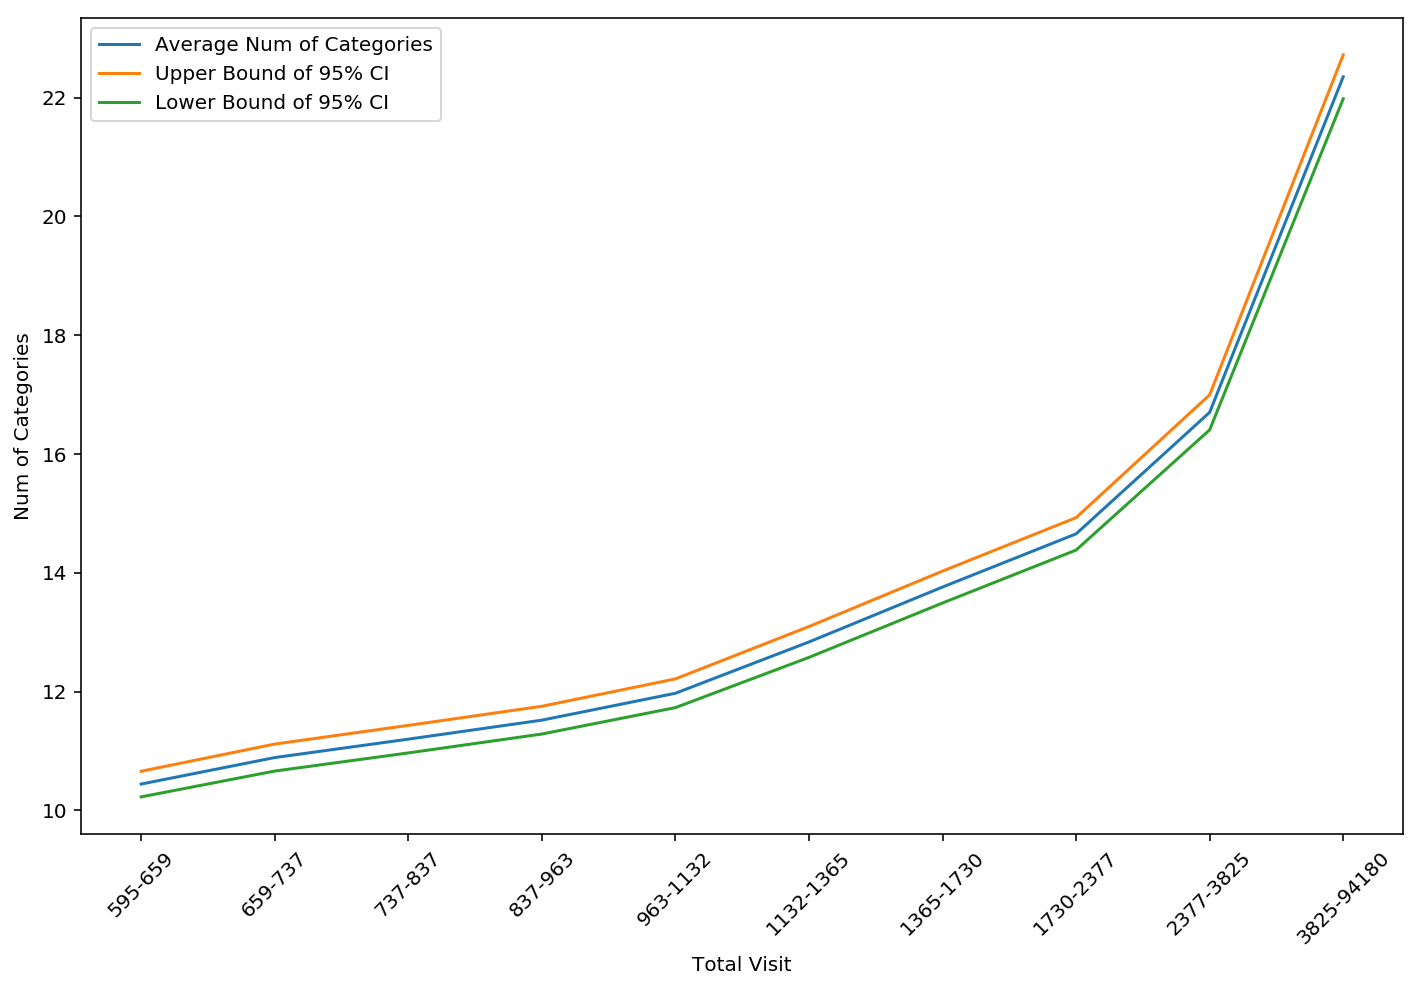

In [9]:
plot_wrt_visit(metadata, 'frequency', 'category_num', 'Num of Categories', 'Average Num of Categories', 'category_plot.png')

In [10]:
page_df = pd.DataFrame.from_csv('data/dump/visit_count_vs_page_length.csv')

/home/xuanli2/penv/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [6]:
list(page_df)

['page_title', 'page_counter', 'page_len', 'Entry', 'Visit Count']

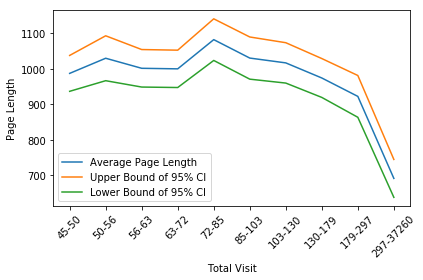

In [7]:
plot_wrt_visit(page_df, 'Visit Count', 'page_len', 'Page Length', 'Average Page Length', 'pagelen_plot.png')

In [11]:
degree_df = load_data("data/dump/graph_info.pkl")

In [12]:
list(degree_df)

['in_degree', 'out_degree', 'freq']

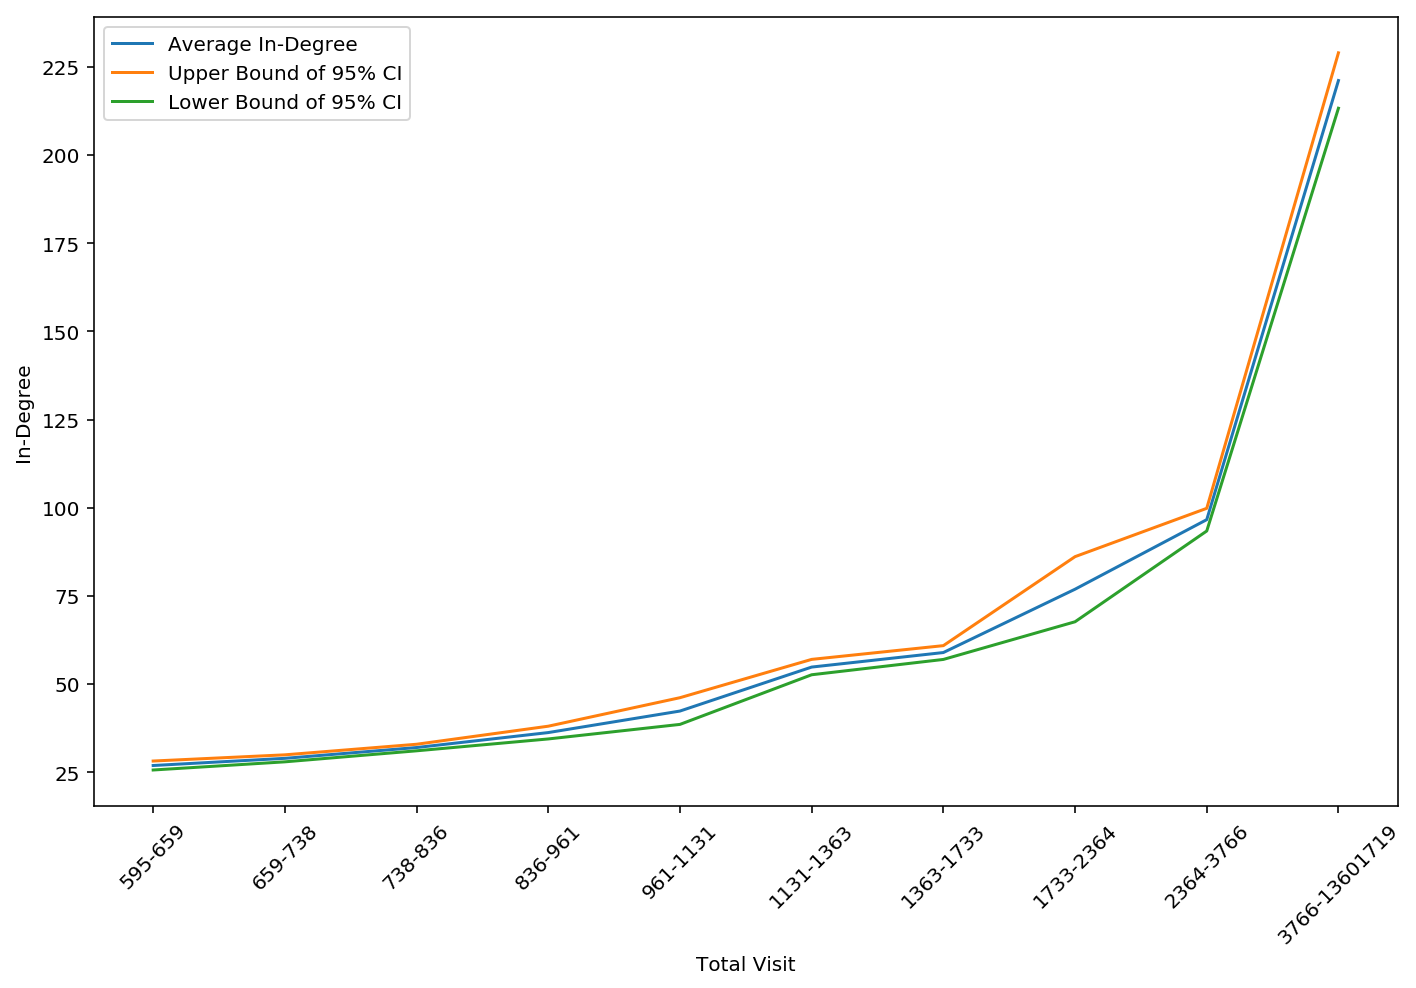

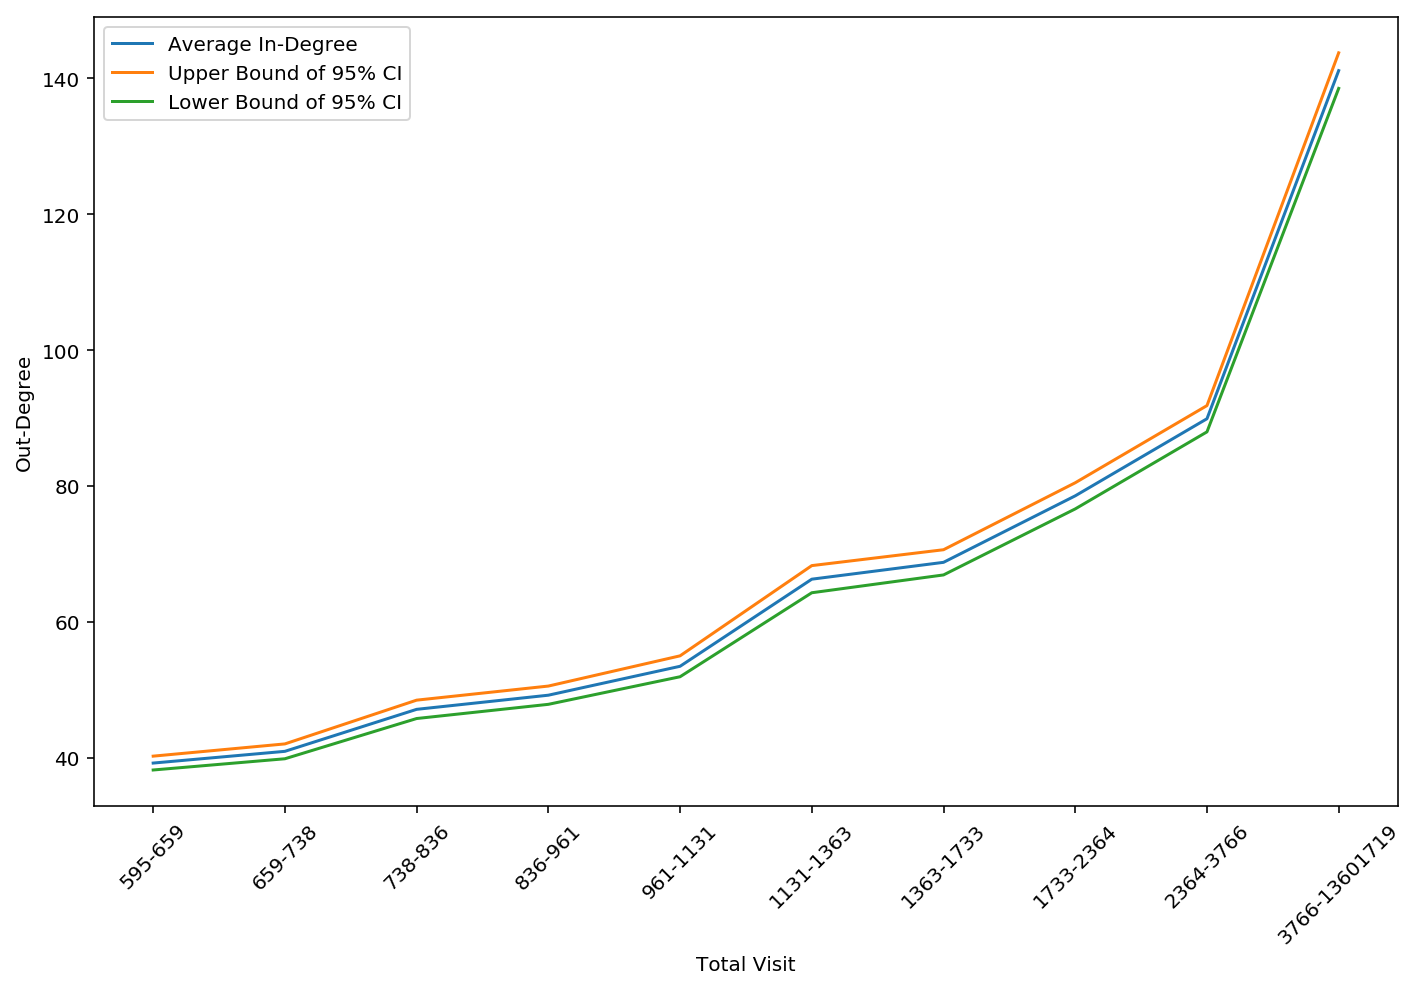

In [14]:
plot_wrt_visit(degree_df, 'freq', 'in_degree', 'In-Degree', 'Average In-Degree', 'in-degree_plot.png')
plot_wrt_visit(degree_df, 'freq', 'out_degree', 'Out-Degree', 'Average In-Degree', 'in-degree_plot.png')

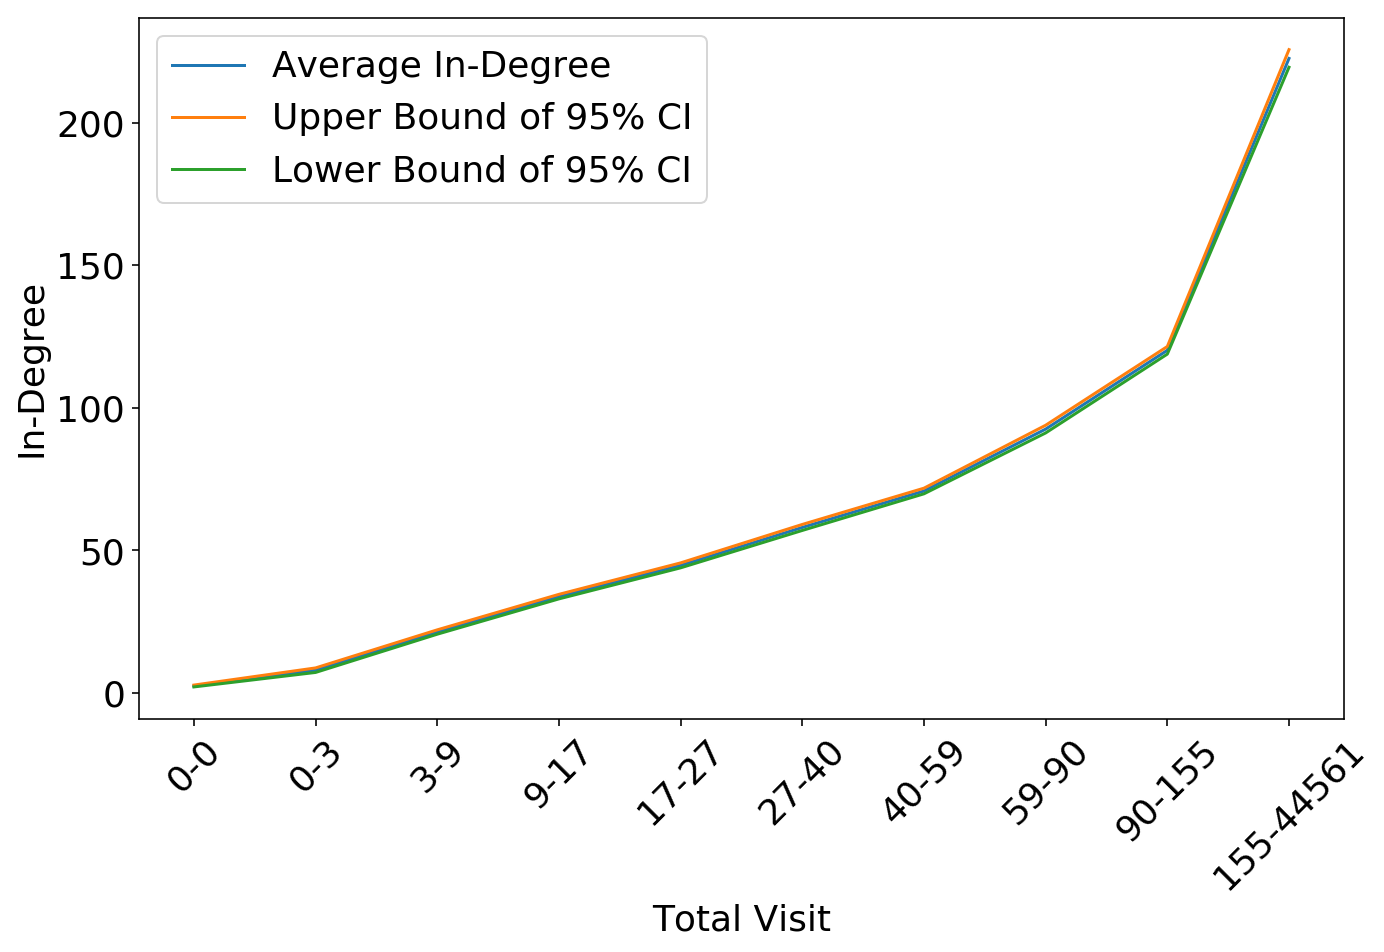

In [24]:
def interval_of_mean(series, alpha):
    x = np.array(series)
    # https://books.google.com/books?id=ZBi1DAAAQBAJ&pg=PA111&lpg=PA111&dq=python+t_%7Bn-1%7D,%5Calpha/2&source=bl&ots=48wZ7PQS7K&sig=rH-nPDg3iKiaB7RKGGMvuAu31H8&hl=en&sa=X&ved=0ahUKEwj4iKrwpNTaAhUlheAKHcz5AS8Q6AEIQDAC#v=onepage&q=python%20t_%7Bn-1%7D%2C%5Calpha%2F2&f=false
    return ss.norm.interval(alpha, loc = np.mean(x), scale = ss.sem(x))

def update_sorted_by_access(dataframe):
    tuples = dataframe.apply(lambda row: (int(row[visit_column_name]), int(row[y_column_name])), axis=1)
    return sorted(tuples, key = lambda x: x[0]) 

sort_list = update_sorted_by_access(dataframe)

fig = plt.figure(figsize=(10,7))
mean_data = []
upper_ci = []
lower_ci = []
xlabels = []
bins = 10
delta = int(len(dataframe) / bins)
for j in range(10):
    update = list(map(lambda x: x[1], sort_list[j * delta: (j+1) * delta]))
    access = list(map(lambda x: x[0], sort_list[j * delta: (j+1) * delta]))
    interval = interval_of_mean(update, 0.95)
    lower_ci.append(interval[0])
    upper_ci.append(interval[1])
    mean_data.append(np.mean(update))
    xlabels.append("{}-{}".format((min(access)), (max(access))))
plt.plot(range(len(mean_data)), mean_data, label = plot_label)
plt.plot(range(len(mean_data)), upper_ci, label = "Upper Bound of 95% CI")
plt.plot(range(len(mean_data)), lower_ci, label = "Lower Bound of 95% CI" )
plt.xticks(range(len(mean_data)), xlabels)
plt.ylabel(ylabel)
plt.xlabel("Total Visit")
plt.legend()
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tight_layout()
plt.show()
fig.savefig("plots/{}".format(output_name), dpi=400)

In [28]:
import seaborn as sns

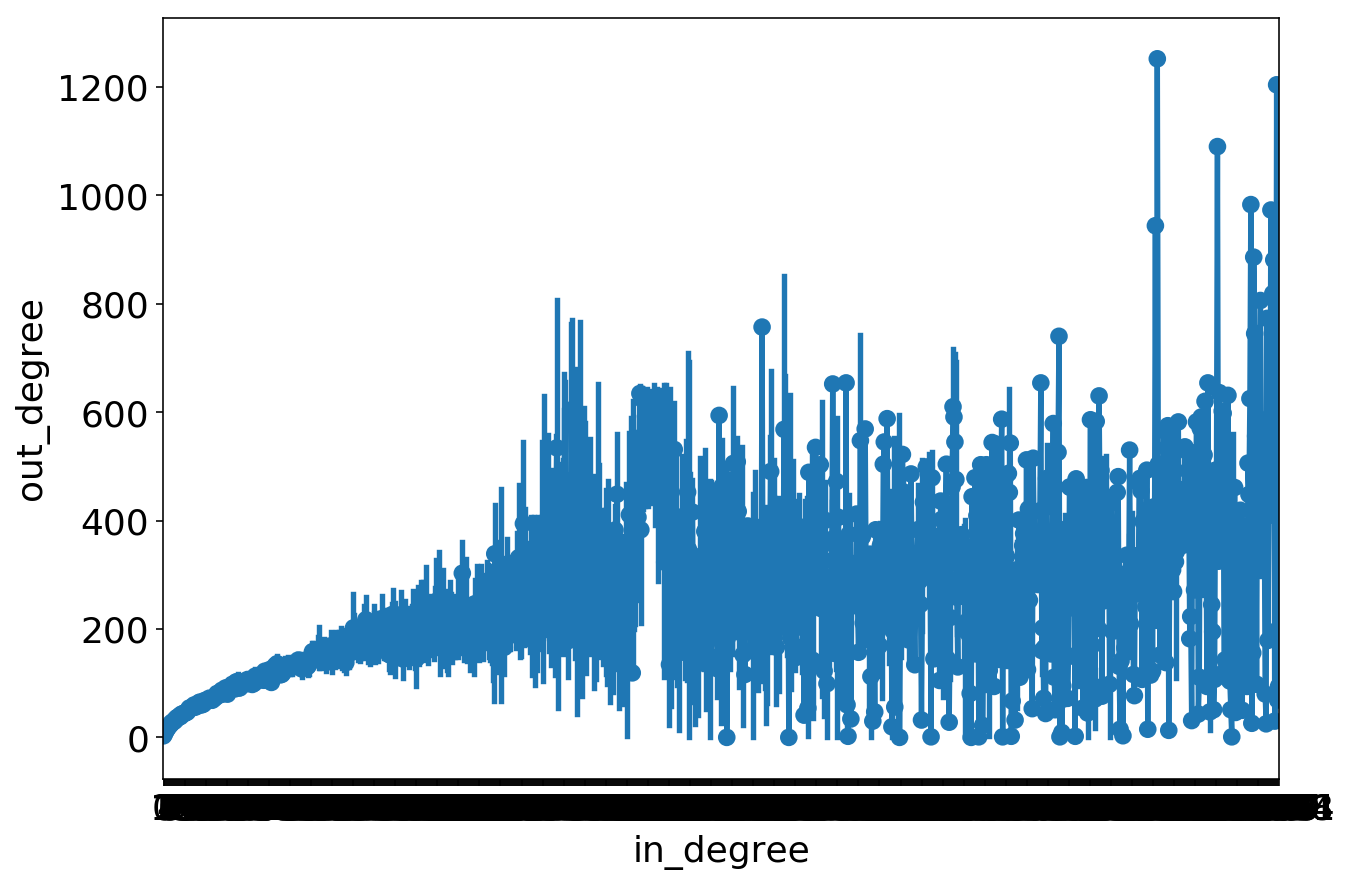

In [29]:
plt.figure(figsize=(10,7))
# plt.plot(degree_df['in_degree'], degree_df['out_degree'], '.', alpha=0.1)
sns.pointplot(x='in_degree',y='out_degree',data=degree_df)
# plt.xlim((0,500))
# plt.ylim((0,1000))
plt.show()